In [1]:
import tensorflow as tf
from scipy.io import loadmat
import random
import math
import tensorflow_probability as tfp


This will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

[Here](https://github.com/aditya9211/SVHN-CNN/blob/master/svhn_model.ipynb) is a github project that uses the same data.



In [2]:
data_location = '/content/drive/MyDrive/mlpapers/GP_Collab_SVHN'

In [3]:
# Run this cell to load the dataset
train = loadmat(f'{data_location}/train_32x32.mat')
test = loadmat(f'{data_location}/test_32x32.mat')
extra = loadmat(f'{data_location}/extra_32x32.mat')

In [4]:
# we have  png files with house numbers for the extra as well, in case of other ideas
# https://stackoverflow.com/questions/15612373/convert-image-png-to-matrix-and-then-to-1d-array


In [94]:
# Set up the imports

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np

import site
import os
import tensorflow as tf
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import errno
import numpy as np
import itertools
import multiprocessing
import json
import datetime
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, SimpleRNN, GRU, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.summary import create_file_writer

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)


In [6]:
print(np.unique(test['y'][:12000])) # just checking that there is no order to the test data
print(train['X'].shape)
print(test['X'].shape)
print(extra['X'].shape)
print(extra['y'].shape)

[ 1  2  3  4  5  6  7  8  9 10]
(32, 32, 3, 73257)
(32, 32, 3, 26032)
(32, 32, 3, 531131)
(531131, 1)


## Inspect and Preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* turn test into validation and slice some extra for test
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel.
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.
# Why greyscale?
* So we get worse performance and have less discriminating features, allowing us to discern the impact of the GP on the features in _collaborative_ learning better.


In [7]:
train_data = train['X']
validation_data = test['X']
test_data = extra['X'][:,:,:,:30000]
train_targets = train['y']
validation_targets = test['y']
test_targets = extra['y'][:30000]

In [8]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = "Label: {0}".format(true_number)
            
        ax.imshow(images[:,:,:,i])
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

def plot_sample(num_sample=10):
    idxs = sorted(random.sample(range(train_targets.shape[0]),num_sample))
    plot_images(train_data[:,:,:,idxs],2,math.ceil(num_sample/2),train_targets[idxs])    
    print(idxs)


[14619, 17341, 20162, 22037, 44193, 48780, 49039, 51775, 53153, 72734]


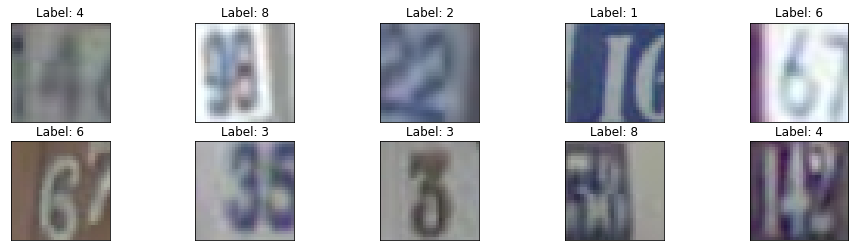

In [9]:
plot_sample(10)

Convert the train, test and validation data to greyscale

In [10]:
train_data_grey = train_data.mean(axis=2)
train_data_grey = np.expand_dims(train_data_grey,axis=2)
train_data_grey = np.moveaxis(train_data_grey, 3, 0)

test_data_grey = test_data.mean(axis=2)
test_data_grey = np.expand_dims(test_data_grey,axis=2)
test_data_grey = np.moveaxis(test_data_grey, 3, 0)

validation_data_grey = validation_data.mean(axis=2)
validation_data_grey = np.expand_dims(validation_data_grey,axis=2)
validation_data_grey = np.moveaxis(validation_data_grey, 3, 0)

print(train_data.shape)
print(train_data_grey.shape)

(32, 32, 3, 73257)
(73257, 32, 32, 1)


Set the 10th class to zero (represents '0' digit)

In [11]:
train_targets[train_targets == 10] = 0
validation_targets[validation_targets == 10] = 0
test_targets[test_targets == 10] = 0

In [12]:
def plot_images_grey(images, nrows, ncols, cls_true):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = "Label: {0}".format(true_number)
        ax.imshow(images[i,:,:,0],cmap='gray', vmin=0, vmax=255)
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

def plot_sample_grey(num_sample=10):
    idxs = sorted(random.sample(range(train_targets.shape[0]),num_sample))
    plot_images_grey(train_data_grey[idxs,:,:,:],2,math.ceil(num_sample/2),train_targets[idxs])    
    print(idxs)


[13608, 21301, 22373, 22626, 44252, 46342, 55229, 64282, 68790, 72162]


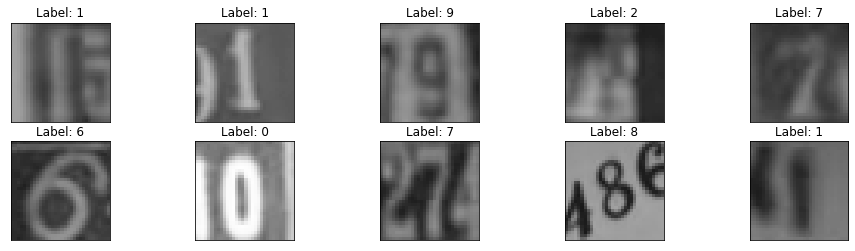

In [13]:
plot_sample_grey(10)

In [14]:
# extracts the layer from a model using the name
def get_layer_by_name(layers, name, return_first=True):
    matching_named_layers = [l for l in layers if l.name == name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers

# make a directory if it does not exist
def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')


Let us do a dumb sequential and see how far this can go  => 78% validation is the best.. + 85% test ?!

In [15]:
# # let's do a dumb sequential and see how far this can go  => 78% validation is the best.. + 85% test ?!

def get_model_seq(input_shape):
    model = Sequential([
                Flatten(name='F1',input_shape=input_shape),
                Dense(128, activation='relu', 
                      name = 'D1'),
                Dense(128, activation='relu', name = 'D2'),
                Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = 'D4R'),                
                Dense(10,  activation='softmax', name = 'SFTMX1')
    ])    
    return model

model_seq = get_model_seq(train_data_grey[0,:,:,:].shape)

# model_seq.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# callbacks_seq = [ EarlyStopping(monitor='val_sparse_categorical_accuracy',
#                            mode='max',
#                            patience=60)
#                 ]

# history_seq = model_seq.fit(  train_data_grey, 
#                       train_targets,
#                       epochs=500, 
#                       validation_data=(validation_data_grey, validation_targets),
#                       callbacks=callbacks_seq,
#                       batch_size=512)

# plot_history(history_seq)
# model_seq.evaluate(test_data_grey,test_targets)

model_seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
F1 (Flatten)                 (None, 1024)              0         
_________________________________________________________________
D1 (Dense)                   (None, 128)               131200    
_________________________________________________________________
D2 (Dense)                   (None, 128)               16512     
_________________________________________________________________
D4R (Dense)                  (None, 48)                6192      
_________________________________________________________________
SFTMX1 (Dense)               (None, 10)                490       
Total params: 154,394
Trainable params: 154,394
Non-trainable params: 0
_________________________________________________________________


In [16]:
# plotting utilities for the history of the fit

def plot_history(history):
    acc_keys = [k for k in history.history.keys() if 'accuracy' in k]
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()

def plot_history_df(history):
    acc_keys = [k for k in history.columns.values if 'accuracy' in k]
    loss_keys = [k for k in history.columns.values if not k in acc_keys and not k in ['epoch']]
    for k, v in history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        if k in loss_keys:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()   


A function that will take a model construction function (with _model_name_ and _input_shape_ arguments), train and fit it using the supplied data and callbacks. The _kwargs_ are supplied to the model fit function.

In [103]:
from tensorflow.keras.callbacks import CSVLogger
import datetime

def compile_and_fit_model_basic(  model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_max_epoch=True,
                                  save_final=False,
                                  patience_count = None,
                                  early_stopping_obs = 'val_sparse_categorical_accuracy',
                                  log_history = True,
                                  verbose_level = 0,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
      
    if 'validation_data' not in kwargs.keys() and 'val_' in early_stopping_obs:
        early_stopping_obs = early_stopping_obs.replace('val_','')

    callbacks_used = []
    if save_max_epoch:
        callbacks_used.append(ModelCheckpoint(f'/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/{m.name}' + '_model_{epoch:03d}_{accuracy:0.3f}',
                                              save_weights_only=False,
                                              monitor = early_stopping_obs,
                                              mode='max',
                                              save_best_only=True))
    if patience_count is not None:
        callbacks_used.append(tf.keras.callbacks.EarlyStopping(monitor=early_stopping_obs, patience=patience_count))

    if log_history:
        callbacks_used.append(tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/history_log_{model_name}_{datetime.date.today().strftime('%Y%m%d')}.csv", append=True))

    m.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=verbose_level, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)

A function that given a model or model directory create a new model up to the _layer_name_, then write the features matching the supplied _X_ and _Y_ as numpy arrays to google drive.

In [18]:
def write_features_from_models(
        model_entry,
        layer_name,
        X_input, Y_input,
        reverse_one_hot=False,
        normalize_X_func=None,
        **kwargs):
  
    Y_new = None
    X_new = None
    if reverse_one_hot:
        Y_new = np.apply_along_axis(np.argmax, 1, Y_input) + 1
    else:
        Y_new = Y_input.copy()

    model_here = None
    if isinstance(model_entry, tf.keras.models.Model):
        model_here = model_entry
        model_file_name = model_here.name
    else:
        model_here = tf.keras.models.load_model(model_entry,**kwargs) 

    features_model = Model(model_here.input,
                            get_layer_by_name(model_here.layers, layer_name).output)
    if normalize_X_func is None:
        X_new = np.array(features_model.predict(X_input), dtype='float64')
    else:
        X_new = np.array(normalize_X_func(features_model.predict(X_input)), dtype='float64')

    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_X", X_new, 
               allow_pickle=True, 
               fix_imports=True)
    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_Y", Y_new, 
               allow_pickle=True, 
               fix_imports=True)



_paper_name_ establishes the reusable name of the paper, it represents the directory under data_papers on the google drive

In [19]:
paper_name = "gpSVHN"

# A basic DNN to fit SVHN

In [20]:
def basic_DNNTemplate_A(model_name, inshape, num_classes = 10):

  base_input = Input(shape=inshape, name='base_input')
  f1_output = Flatten(name='F1')(base_input)
  d1_output = Dense(128, activation='relu', name = 'D1')(f1_output)
  d2_output = Dense(128, activation='relu', name = 'D2')(d1_output)
  d3r_output = Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = 'D3R')(d2_output)
  model_output = Dense(10,  activation='softmax', name = 'SFTMX1')(d3r_output)
  model = Model(base_input, model_output, name = model_name)

  return model

In [21]:
train_data_grey[0,:,:,:].shape

(32, 32, 1)

In [22]:
# saving 100 DNNs

# for model_count in [i+1 for i in range(100)]:
#   m1, h1 = compile_and_fit_model_basic( basic_DNNTemplate_A,  
#                     f"DNN_A_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
#                     train_data_grey[0,:,:,:].shape, 
#                     train_data_grey, train_targets,
#                     save_max_epoch=False,
#                     save_final=True,
#                     patience_count = 35,
#                     early_stopping_obs = 'val_sparse_categorical_accuracy',
#                     log_history = True,                             
#                     batch_size=512, 
#                     epochs=250, 
#                     class_weight=None, 
#                     validation_data=(test_data_grey, test_targets))


# /content/drive/MyDrive/data_papers/gpSVHN/model_finals/DNN_A_6_20210923210545_saved_model_after_fit/assets

In [23]:
# saving the features of 100 DNNs

# check_model_string = "DNN_A_"

# for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
#   if os.path.isdir(dir_entry):
#     if check_model_string in str(dir_entry):
#       print(dir_entry.name)
#       write_features_from_models(
#         f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
#         "D3R",
#         validation_data_grey, validation_targets,
#         reverse_one_hot=False,
#         normalize_X_func=None)

# # I switched test and validation...


# A basic CNN to fit SVHN

In [24]:
def basic_CNNTemplate_A(model_name, inshape, num_classes = 10):
  # Input Layer
  base_input = Input(shape=inshape, name='base_input')
  # Convolutional Layer #1
  c1_output = Conv2D(filters=32,kernel_size=[5, 5],padding="same",activation="relu", name="C1")(base_input)

  # Pooling Layer #1
  mxp1_output = MaxPooling2D(pool_size=[2, 2], strides=2, name="MXP1")(c1_output)
  c2_output = Conv2D(filters=64,kernel_size=[5, 5],padding="same",activation="relu",name="C2")(mxp1_output)
    
  #with tf.name_scope('Pool2 Layer'):
  mxp2_output = MaxPooling2D(pool_size=[2, 2], strides=2, name="MXP2")(c2_output)
  f1_output = Flatten(name='F1')(mxp2_output)

  # Dense Layer
  d1_output = Dense(units=256, activation="relu", name="D1")(f1_output)
  drp1_output = Dropout(rate=0.5, name="DRP1")(d1_output)

  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(drp1_output)
  model = Model(base_input, model_output, name = model_name)
  return model


In [25]:
# # saving 100 CNNs
# for model_count in [i+1 for i in range(100)]:
#   m1, h1 = compile_and_fit_model_basic( basic_CNNTemplate_A,  
#                     f"CNN_A_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
#                     train_data_grey[0,:,:,:].shape, 
#                     train_data_grey, train_targets,
#                     save_max_epoch=False,
#                     save_final=True,
#                     patience_count = 35,
#                     early_stopping_obs = 'val_sparse_categorical_accuracy',
#                     log_history = True,                             
#                     batch_size=512, 
#                     epochs=250, 
#                     class_weight=None, 
#                     validation_data=(test_data_grey, test_targets))


# # /content/drive/MyDrive/data_papers/gpSVHN/model_finals/DNN_A_6_20210923210545_saved_model_after_fit/assets
# plot_history(h1)

In [26]:
# # saving the features of 100 CNNs

# # /content/drive/MyDrive/data_papers/gpSVHN/model_finals/CNN_A_
# check_model_string = "CNN_A_"
# for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
#   if os.path.isdir(dir_entry):
#     if check_model_string in str(dir_entry):
#       print(dir_entry.name)
#       write_features_from_models(
#         f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
#         "DRP1",
#         validation_data_grey, validation_targets,
#         reverse_one_hot=False,
#         normalize_X_func=None)

Some functions to get scores on the results

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def get_confusion_matrix_classification(model, X, Y_true):
    y_pred = model.predict(X)
    y_true = np.apply_along_axis(np.argmax, 1, Y_true)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def construct_confusion_matrix(X, Y_true, Y_pred):
    y_true = Y_true
    y_pred = np.apply_along_axis(np.argmax, 1, Y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def pr_rc_f1_acc_from_supplied(y_pred, y_true):  
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")   
    acc = accuracy_score(y_true, y_pred)
    return pr, rc, f1, acc


Set up the models, CNN/DNN splits for reuse

In [80]:
acceptable_string_grabs = [ "CNN_A_", "DNN_A_"]
model_dirs = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}" 
                for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/") 
                if os.path.isdir(dir_entry) and any(xs in dir_entry.name for xs in acceptable_string_grabs) ]
dnn_model_dirs = [ s for s in model_dirs if "DNN" in s ] 
cnn_model_dirs = [ s for s in model_dirs if "CNN" in s ] 
model_features_files = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{file_entry.name}" 
                for file_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/") 
                if os.path.isfile(file_entry) and any(xs in file_entry.name for xs in acceptable_string_grabs) ]
dnn_features_files = [ s for s in model_features_files if "DNN" in s ] 
cnn_features_files = [ s for s in model_features_files if "CNN" in s ] 

dnn_identifier = acceptable_string_grabs[1]
dnn_layer_name = "DRP1"

cnn_identifier = acceptable_string_grabs[0]
cnn_layer_name = "D3R"

def avgfilter_ensemble_predictions(y_pred_ms, xtest):
  y_preds_ens_prb = np.apply_along_axis(np.mean, 0, y_pred_ms)
  y_preds_ens_idx = np.apply_along_axis(np.argmax, 1, y_preds_ens_prb) 
  # y_preds_ens_idx = y_preds_ens_idx + 1
  return y_preds_ens_idx  




# Set up ensembles of 20 DNN, 20 CNN or 10 CNN/10 DNN to predict (randomly assembled from the 100 before)

In [83]:
num_of_repeats = 10
num_of_models = 20

x_input = validation_data_grey
y_input = validation_targets

# create traditional ensemble of 20 DNNs 
scores_dnn20 = []
for repc in range(num_of_repeats):
  dnn_models_to_use = [ tf.keras.models.load_model(mfile) for mfile in sorted(random.sample(dnn_model_dirs, num_of_models))]
  dnn_model_predictions = [ model.predict(x_input) for model in dnn_models_to_use]
  y_ens_preds = avgfilter_ensemble_predictions(dnn_model_predictions, x_input)
  scores_dnn20.append(pr_rc_f1_acc_from_supplied(y_ens_preds,y_input))

# create traditional ensemble of 20 CNNs 
scores_cnn20 = []
for repc in range(num_of_repeats):
  cnn_models_to_use = [ tf.keras.models.load_model(mfile) for mfile in sorted(random.sample(cnn_model_dirs, num_of_models))]
  cnn_model_predictions = [ model.predict(x_input) for model in cnn_models_to_use]
  y_ens_preds = avgfilter_ensemble_predictions(cnn_model_predictions, x_input)
  scores_cnn20.append(pr_rc_f1_acc_from_supplied(y_ens_preds,y_input))




In [85]:
num_of_repeats = 10
num_of_models = 20

x_input = validation_data_grey
y_input = validation_targets

# create traditional ensemble of 10 CNNs and 10 DNNs
scores_cnn10dnn10 = []
for repc in range(num_of_repeats):
  cnn_models_to_use = [ tf.keras.models.load_model(mfile) for mfile in sorted(random.sample(cnn_model_dirs, int(num_of_models/2)))]
  cnn_model_predictions = [ model.predict(x_input) for model in cnn_models_to_use]
  dnn_models_to_use = [ tf.keras.models.load_model(mfile) for mfile in sorted(random.sample(dnn_model_dirs, int(num_of_models/2)))]
  models_to_use = cnn_models_to_use
  models_to_use.extend(dnn_models_to_use)
  model_predictions = [ model.predict(x_input) for model in models_to_use]
  y_ens_preds = avgfilter_ensemble_predictions(model_predictions, x_input)
  scores_cnn10dnn10.append(pr_rc_f1_acc_from_supplied(y_ens_preds,y_input))



Save the score results of the ensembles

In [93]:
# dnn_model_predictions[0].shape
# construct_confusion_matrix(x_input, y_input, dnn_model_predictions[0] )
# y_ens_preds = avgfilter_ensemble_predictions(dnn_model_predictions, x_input)
# y_input

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_dnn20_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_dnn20), 
               allow_pickle=True, 
               fix_imports=True)
np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_cnn20_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_cnn20), 
               allow_pickle=True, 
               fix_imports=True)
np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_cnn10dnn10_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_cnn10dnn10), 
               allow_pickle=True, 
               fix_imports=True)



# Parallel model with no GP and no collaborative but with different parallel DNN/CNN streams. The _best_ parallel model.

function for basic parallel 20 DNN

In [100]:
def basic_ParallelDNN_A(model_name, inshape, num_classes = 10, num_of_parallels = 20):

  base_input = Input(shape=inshape, name='base_input')
  f1_output = Flatten(name='F1')(base_input)

  d3rs = []
  for pc in range(num_of_parallels):
    d1_output = Dense(128, activation='relu', name = f'p{pc+1}_D1')(f1_output)
    d2_output = Dense(128, activation='relu', name = f'p{pc+1}_D2')(d1_output)
    d3r_output = Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = f'p{pc+1}_D3R')(d2_output)
    d3rs.append(d3r_output)

  # merging_layer = tf.keras.layers.concatenate(d3rs)
  concat1_output = Concatenate(name="CONCAT1")(d3rs)
  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(concat1_output)
  model = Model(base_input, model_output, name = model_name)

  return model

function for basic parallel 20 CNN

In [111]:
def basic_ParallelCNN_A(model_name, inshape, num_classes = 10, num_of_parallels = 20):

  # Input Layer
  base_input = Input(shape=inshape, name='base_input')

  drp1s = []
  for pc in range(num_of_parallels):
    c1_output = Conv2D(filters=32,kernel_size=[5, 5],padding="same",activation="relu", name=f"p{pc+1}_C1")(base_input)
    mxp1_output = MaxPooling2D(pool_size=[2, 2], strides=2, name=f"p{pc+1}_MXP1")(c1_output)
    c2_output = Conv2D(filters=64,kernel_size=[5, 5],padding="same",activation="relu",name=f"p{pc+1}_C2")(mxp1_output)
    mxp2_output = MaxPooling2D(pool_size=[2, 2], strides=2, name=f"p{pc+1}_MXP2")(c2_output)
    f1_output = Flatten(name=f"p{pc+1}_F1")(mxp2_output)
    d1_output = Dense(units=256, activation="relu", name=f"p{pc+1}_D1")(f1_output)
    drp1_output = Dropout(rate=0.5, name=f"p{pc+1}_DRP1")(d1_output)
    drp1s.append(drp1_output)

  concat1_output = Concatenate(name="CONCAT1")(drp1s)
  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(concat1_output)
  model = Model(base_input, model_output, name = model_name)
  return model


function for basic parallel 10 CNN + 10 DNN

In [108]:
def basic_ParallelCNNDNN_A(model_name, inshape, num_classes = 10, num_of_parallels = 20):

  # Input Layer
  base_input = Input(shape=inshape, name='base_input')

  to_merge = []
  for pc in range(int(num_of_parallels/2)):
    c1_output = Conv2D(filters=32,kernel_size=[5, 5],padding="same",activation="relu", name=f"p{pc+1}_C1_CNN")(base_input)
    mxp1_output = MaxPooling2D(pool_size=[2, 2], strides=2, name=f"p{pc+1}_MXP1_CNN")(c1_output)
    c2_output = Conv2D(filters=64,kernel_size=[5, 5],padding="same",activation="relu",name=f"p{pc+1}_C2_CNN")(mxp1_output)
    mxp2_output = MaxPooling2D(pool_size=[2, 2], strides=2, name=f"p{pc+1}_MXP2_CNN")(c2_output)
    f1_output = Flatten(name=f"p{pc+1}_F1_CNN")(mxp2_output)
    d1_output = Dense(units=256, activation="relu", name=f"p{pc+1}_D1_CNN")(f1_output)
    drp1_output = Dropout(rate=0.5, name=f"p{pc+1}_DRP1_CNN")(d1_output)
    to_merge.append(drp1_output)

  for pc in range(int(num_of_parallels/2)):
    d1_output = Dense(128, activation='relu', name = f'p{pc+1}_D1_DNN')(f1_output)
    d2_output = Dense(128, activation='relu', name = f'p{pc+1}_D2_DNN')(d1_output)
    d3r_output = Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = f'p{pc+1}_D3R_DNN')(d2_output)
    to_merge.append(d3r_output)

  concat1_output = Concatenate(name="CONCAT1")(to_merge)
  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(concat1_output)
  model = Model(base_input, model_output, name = model_name)
  return model


In [ ]:
 # parallel 20 DNN
 
 pdnn20, pdnn20h = compile_and_fit_model_basic( basic_ParallelDNN_A,  
                    f"ParallelDNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level = 1,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(test_data_grey, test_targets))

# /content/drive/MyDrive/data_papers/gpSVHN/model_finals/ParallelDNN_A_20211002170140_saved_model_after_fit/assets  # 88% validation

In [112]:
 pcnn20, pcnn20h = compile_and_fit_model_basic( basic_ParallelCNN_A,  
                    f"ParallelCNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level = 1,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(test_data_grey, test_targets))
 



Epoch 1/250
144/144 [==============================] - 31s 195ms/step - loss: 10.8030 - sparse_categorical_accuracy: 0.5761 - val_loss: 0.4221 - val_sparse_categorical_accuracy: 0.8814
Epoch 2/250
144/144 [==============================] - 27s 190ms/step - loss: 0.5715 - sparse_categorical_accuracy: 0.8365 - val_loss: 0.3197 - val_sparse_categorical_accuracy: 0.9145
Epoch 3/250
144/144 [==============================] - 27s 190ms/step - loss: 0.4799 - sparse_categorical_accuracy: 0.8630 - val_loss: 0.2894 - val_sparse_categorical_accuracy: 0.9197
Epoch 4/250
144/144 [==============================] - 27s 190ms/step - loss: 0.4211 - sparse_categorical_accuracy: 0.8806 - val_loss: 0.2687 - val_sparse_categorical_accuracy: 0.9289
Epoch 5/250
144/144 [==============================] - 27s 190ms/step - loss: 0.3900 - sparse_categorical_accuracy: 0.8891 - val_loss: 0.2505 - val_sparse_categorical_accuracy: 0.9326
Epoch 6/250
144/144 [==============================] - 27s 190ms/step - loss: 0

In [ ]:
 pdcnn20, pdcnn20h = compile_and_fit_model_basic( basic_ParallelCNNDNN_A,  
                    f"ParallelCNNDNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level = 1,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(test_data_grey, test_targets))

Epoch 1/250
144/144 [==============================] - 18s 109ms/step - loss: 25.1268 - sparse_categorical_accuracy: 0.5813 - val_loss: 8.6848 - val_sparse_categorical_accuracy: 0.8856
Epoch 2/250
144/144 [==============================] - 15s 105ms/step - loss: 6.3270 - sparse_categorical_accuracy: 0.8329 - val_loss: 4.6015 - val_sparse_categorical_accuracy: 0.9166
Epoch 3/250
144/144 [==============================] - 15s 105ms/step - loss: 3.9162 - sparse_categorical_accuracy: 0.8621 - val_loss: 3.0018 - val_sparse_categorical_accuracy: 0.9203
Epoch 4/250
144/144 [==============================] - 15s 105ms/step - loss: 2.6226 - sparse_categorical_accuracy: 0.8771 - val_loss: 2.0021 - val_sparse_categorical_accuracy: 0.9316
Epoch 5/250
144/144 [==============================] - 15s 105ms/step - loss: 1.7967 - sparse_categorical_accuracy: 0.8877 - val_loss: 1.3714 - val_sparse_categorical_accuracy: 0.9294
Epoch 6/250
144/144 [==============================] - 15s 105ms/step - loss: 1

In [ ]:
plot_history(pdcnn20h)
plot_history(pcnn20h)
plot_history(pdnn20h)

 the summary results for the fully parallel models

In [ ]:
x_input = validation_data_grey
y_input = validation_targets

models_to_use = [pdnn20, pcnn20, pdcnn20]
model_predictions = [ model.predict(x_input) for model in models_to_use]

y_preds = [ np.apply_along_axis(np.argmax, 1, y_pred_model) for y_pred_model in model_predictions ] 

scores_pdnn20_pcnn20_pdcnn20 = [ pr_rc_f1_acc_from_supplied(y_pred,y_input) for y_pred in y_preds ]

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_dnn20_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_dnn20), 
               allow_pickle=True, 
               fix_imports=True)




## Inspect and Preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* turn test into validation and slice some extra for test
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel.
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.
# Why greyscale?
* So we get worse performance and have less discriminating features, allowing us to discern the impact of the GP on the features in _collaborative_ learning better.


In [77]:
print(confusion_matrix(y_input, y_ens_preds))
print(precision_recall_fscore_support(y_input, y_ens_preds,average="weighted"))
print(accuracy_score(y_input, y_ens_preds))

# y_true, y_pred, average="weighted"



[[1436   53   37   51   15   12   53   24   12   51]
 [  63 4603   83   57   89   12   31  117   22   22]
 [  11   59 3660   85   51   54   48   90   32   59]
 [  24  121   93 2224   36  101   27   28   52  176]
 [  24   84   62   43 2179   13   35   15   20   48]
 [  17   33   35  158   34 1914  101   20   42   30]
 [  38   54   28   51   57   90 1585   13   43   18]
 [  10  106   54   18    7   32   18 1747    7   20]
 [  45   40   24   67   33   36  123    4 1231   57]
 [  40   38   61   49   24   41   24   17   19 1282]]
(0.8402949716180842, 0.8397741241548863, 0.8396644720098586, None)
0.8397741241548863


In [64]:
# np.unique(y_input).size
# np.eye([i for i in range(np.unique(y_input).size)])[y_input]
# print(np.eye(np.unique(y_input).size)[y_input])
# print(y_input)



[[[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 1. ... 0. 0. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 1. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 1. 0. 0.]]]
[[5]
 [2]
 [1]
 ...
 [7]
 [6]
 [7]]


In [ ]:

import re
import random

# create DNN of 10 feature outputs
dnn_identifier = acceptable_string_grabs[1]
dnn_layer_name = "DRP1"
dnn_models_to_use = sorted(random.sample(dnn_model_dirs, 10))
dnn_features_identifiers = []
pHere = re.compile("^.*" + f"({dnn_identifier}\d+_\d+)_saved_model_after_fit$")
dnn_feature_strings_to_match = sorted([ pHere.search(s).group(1) for s in dnn_models_to_use ])
dnn_feature_files_selected_x = sorted([ff for ff in dnn_features_files if any(ss in ff for ss in dnn_feature_strings_to_match) and "_X.npy" in ff])






In [41]:
dnn_feature_files_selected

# dnn_features_files

['/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_100_20210923232849_features_D3R_X.npy',
 '/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_16_20210923212223_features_D3R_X.npy',
 '/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_27_20210923213503_features_D3R_X.npy',
 '/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_34_20210923214719_features_D3R_X.npy',
 '/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_38_20210923215402_features_D3R_X.npy',
 '/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_45_20210923220436_features_D3R_X.npy',
 '/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_47_20210923220817_features_D3R_X.npy',
 '/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_7_20210923210808_features_D3R_X.npy',
 '/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_89_20210923231119_features_D3R_X.npy',
 '/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A

In [ ]:
def get_confusion_matrix_classification(model, X, Y_true):
    y_pred = model.predict(X)
    y_true = np.apply_along_axis(np.argmax, 1, Y_true)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def misclass_perc_to_weight(input_confusion, add_base=True, func=None):
    perc_misclassified = 1.0 - np.array([ input_confusion[x,x] for x in np.arange(input_confusion.shape[0]).tolist() ])/input_confusion.sum(axis=1)
    
    base_val = min(perc_misclassified[perc_misclassified>0.0])
    if add_base:        
        perc_misclassified = perc_misclassified + base_val
    
    perc_misclassified = [ x/base_val for x in perc_misclassified]
    return dict([ (idx, func(perc_val)) if func is not None else (idx, perc_val) for idx, perc_val in enumerate(perc_misclassified) ])

def prf(model,xtest, ytest):
  y_pred = np.apply_along_axis(np.argmax, 1, model.predict(xtest))
  y_true = np.apply_along_axis(np.argmax, 1, ytest)
  return precision_recall_fscore_support(y_true, y_pred, average="weighted")

def get_sp_pr_rc_f1(model,xtest, ytest):  
    y_pred = np.apply_along_axis(np.argmax, 1, model.predict(xtest))
    y_true = np.apply_along_axis(np.argmax, 1, ytest)
    cmres = ConfusionMatrix(actual_vector=y_true,predict_vector=y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")   
    return cmres.TNR_Macro, pr, rc, f1
 
def get_sp_pr_rc_f1_acc(model,xtest, ytest):  
    spec, pr, rc, f1 = get_sp_pr_rc_f1(model,xtest, ytest)
    acc = model.evaluate(xtest,ytest)[-1]        
    return spec, pr, rc, f1, acc
 
def get_sp_pr_rc_f1_acc_supplied(y_pred, y_true):  
    cmres = ConfusionMatrix(actual_vector=y_true,predict_vector=y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")   
    acc = accuracy_score(y_true, y_pred)
    return cmres.TNR_Macro, pr, rc, f1, acc

def maxfilter_ensemble_predictions(ms, xtest):
  y_pred_ms = np.array([ mx.predict(xtest) for mx in ms ])
  y_preds_ens_idx = np.apply_along_axis(np.argmax, 2, y_pred_ms) 
  y_preds_ens_prb = np.apply_along_axis(np.max, 2, y_pred_ms) 
  idxs_with_differences = np.argwhere(np.apply_along_axis(lambda x: np.max(x) != np.min(x),0,y_preds_ens_idx)).flatten()
  y_preds_ens_final = y_preds_ens_idx[0]
  y_preds_ens_final[idxs_with_differences] = y_preds_ens_idx[np.apply_along_axis(np.argmax,0,y_preds_ens_prb[:,idxs_with_differences]),idxs_with_differences]
  return y_preds_ens_final

def avgfilter_ensemble_predictions(ms, xtest):
  y_pred_ms = np.array([ mx.predict(xtest) for mx in ms ])
  y_preds_ens_prb = np.apply_along_axis(np.mean, 0, y_pred_ms)
  y_preds_ens_idx = np.apply_along_axis(np.argmax, 1, y_preds_ens_prb) 
  # y_preds_ens_idx = y_preds_ens_idx + 1
  return y_preds_ens_idx  

In [ ]:
# create Traditional Ensemble A&E results

# load model A and model E from disk
model_cnn_A = load_model(f"/content/drive/MyDrive/data_papers/ncRNA/model_checkpoints/cnn_A_256_20210827212633_model_491_0.995")
model_rnn_E = load_model(f"/content/drive/MyDrive/data_papers/ncRNA/model_checkpoints/rnn_E_20210827221034_model_060_0.983")

ms = [model_cnn_A, model_rnn_E]

aens_AE_test_nums = get_sp_pr_rc_f1_acc_supplied(averaged_ensemble_predictions(ms, X_test_1000e)+1,reverse_one_hot(Y_test_1000e))
aens_AE_val_nums = get_sp_pr_rc_f1_acc_supplied(averaged_ensemble_predictions(ms, X_val_1000e)+1,reverse_one_hot(Y_val_1000e))
aens_AE_train_nums = get_sp_pr_rc_f1_acc_supplied(averaged_ensemble_predictions(ms, X_train_1000e)+1,reverse_one_hot(Y_train_1000e))

In [ ]:

def get_combined_features_from_models(
        to_combine,
        X_train_combined, Y_train_combined,
        X_validation_combined, Y_validation_combined,
        X_test_combined, Y_test_combined,
        reverse_one_hot=False,
        normalize_X_func=None):
    models = []
    models_dict = {}
    X_trains_out = []
    X_test_out = []
    X_validation_out = []
    XY_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: None))))

    if reverse_one_hot:
        Y_train_new = np.apply_along_axis(np.argmax, 1, Y_train_combined) + 1
        Y_test_new = np.apply_along_axis(np.argmax, 1, Y_test_combined) + 1
        Y_validation_new = np.apply_along_axis(np.argmax, 1, Y_validation_combined) + 1
    else:
        Y_train_new = Y_train_combined.copy()
        Y_test_new = Y_test_combined.copy()
        Y_validation_new = np.apply_along_axis(np.argmax, 1, Y_validation_combined) + 1

    for model_file_name, layer_name, kwargs in to_combine:
        model_here = None
        if isinstance(model_file_name, tf.keras.models.Model):
            model_here = model_file_name
            model_file_name = model_here.name
        else:
            if model_file_name in models_dict.keys():
                model_here = models_dict[model_file_name]
            else:
                model_here = tf.keras.models.load_model(model_file_name,
                                                        **kwargs) if kwargs is not None else tf.keras.models.load_model \
                    (model_file_name)

        features_model = Model(model_here.input,
                               get_layer_by_name(model_here.layers, layer_name).output)
        if normalize_X_func is None:
            X_trains_out.append(np.array(features_model.predict(X_train_combined), dtype='float64'))
            X_test_out.append(np.array(features_model.predict(X_test_combined), dtype='float64'))
            X_validation_out.append(np.array(features_model.predict(X_validation_combined), dtype='float64'))
        else:
            X_trains_out.append(np.array(normalize_X_func(features_model.predict(X_train_combined)), dtype='float64'))
            X_test_out.append(np.array(normalize_X_func(features_model.predict(X_test_combined)), dtype='float64'))
            X_validation_out.append(np.array(normalize_X_func(features_model.predict(X_validation_combined)), dtype='float64'))
            
        XY_dict[model_file_name][layer_name]['Train']['X'] = X_trains_out[-1]
        XY_dict[model_file_name][layer_name]['Train']['Y'] = Y_train_new
        
        XY_dict[model_file_name][layer_name]['Test']['X'] = X_test_out[-1]
        XY_dict[model_file_name][layer_name]['Test']['Y'] = Y_test_new
        
        XY_dict[model_file_name][layer_name]['Validation']['X'] = X_validation_out[-1]
        XY_dict[model_file_name][layer_name]['Validation']['Y'] = Y_validation_new
        
        
        models.append(((model_file_name, layer_name), (model_here, features_model)))
        models_dict[model_file_name] = model_here

    X_train_new = np.concatenate(tuple(X_trains_out), axis=1)
    X_test_new = np.concatenate(tuple(X_test_out), axis=1)
    X_validation_new = np.concatenate(tuple(X_validation_out), axis=1)


    data_train = (X_train_new, Y_train_new)
    data_test = (X_test_new, Y_test_new)
    data_validation = (X_validation_new, Y_validation_new)

    return models, data_train, data_validation, data_test, XY_dict



In [1]:
def compile_and_fit_model_collaborative(  
        m1, m1_layer_name,
        m2, m2_layer_name,
        input_shape,
        X_train,
        Y_train,
        X_validation,
        Y_validation,
        X_test,
        Y_test,
        save_max_epoch=True,
        save_final=False,
        patience_count = None,
        log_history = True,
        merged_name = None,
        **kwargs):
    
    to_combine_ld_no2nd_rNo2nd = [
        (m1 , m1_layer_name, None),   # change to the appropriate dense layer name
        (m2, m2_layer_name, None) # change to the appropriate dense layer name
    ]
    
    # models, data_train, data_validation, data_test, XY_dict
    combined_models_ld, data_train_ld, data_validation_ld, data_test_ld, data_access_ld = get_combined_features_from_models(
        to_combine_ld_no2nd_rNo2nd ,
        X_train,
        Y_train,
        X_validation,
        Y_validation,
        X_test, 
        Y_test, 
        reverse_one_hot=False)
        
    rcnn_combine_model = model_combination(f"collaborative_model_{m1.name}_{m2.name}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                                           data_train_ld[0][0].shape  ) if merged_name is None else model_combination(merged_name, data_train_ld[0][0].shape  )
    rcnn_combine_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
    if patience_count is None:
        patience_count  = 10000    
    callbacks_used_rcnn_combine = [
                        ModelCheckpoint(f'/content/drive/MyDrive/data_papers/ncRNA/model_checkpoints/{rcnn_combine_model.name}' + '_model_{epoch:03d}_{accuracy:0.3f}',
                                                save_weights_only=False,
                                                monitor='accuracy',
                                                mode='max',
                                                save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(patience=patience_count),
                        tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/ncRNA/data/history/history_log_{rcnn_combine_model.name}_{datetime.date.today().strftime('%Y%m%d')}.csv", append=True)
                        ]
    
    history_rcnn_combine = rcnn_combine_model.fit(data_train_ld[0], 
                                                  data_train_ld[1], 
                                                  validation_data=(data_validation_ld[0],to_categorical(data_validation_ld[1]-1)),
                                                  callbacks=callbacks_used_rcnn_combine, 
                                                  verbose=2, 
                                                  **kwargs)
    rcnn_combine_model.save(f"/content/drive/MyDrive/data_papers/ncRNA/model_checkpoints/{rcnn_combine_model.name}.h5")    
    # rcnn_combine_model.evaluate(data_test_ld_no2nd_rNo2nd[0],data_test_ld_no2nd_rNo2nd[1][0]) 
    
    return (rcnn_combine_model, history_rcnn_combine, data_access_ld )

In [ ]:
def get_features_from_models(
        to_combine,
        X_input, Y_input,
        reverse_one_hot=False,
        normalize_X_func=None):
    models = []
    models_dict = {}
    X_out = []
    XY_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: None))))

    if reverse_one_hot:
        Y_new = np.apply_along_axis(np.argmax, 1, Y_input) + 1
    else:
        Y_new = Y_input.copy()

    for model_file_name, layer_name, kwargs in to_combine:
        model_here = None
        if isinstance(model_file_name, tf.keras.models.Model):
            model_here = model_file_name
            model_file_name = model_here.name
        else:
            if model_file_name in models_dict.keys():
                model_here = models_dict[model_file_name]
            else:
                model_here = tf.keras.models.load_model(model_file_name,
                                                        **kwargs) if kwargs is not None else tf.keras.models.load_model \
                    (model_file_name)

        features_model = Model(model_here.input,
                               get_layer_by_name(model_here.layers, layer_name).output)
        if normalize_X_func is None:
            X_out.append(np.array(features_model.predict(X_input), dtype='float64'))
        else:
            X_out.append(np.array(normalize_X_func(features_model.predict(X_input)), dtype='float64'))
            
        XY_dict[model_file_name][layer_name]['Features']['X'] = X_out[-1]
        XY_dict[model_file_name][layer_name]['Actual']['Y'] = Y_new
        
        models.append(((model_file_name, layer_name), (model_here, features_model)))
        models_dict[model_file_name] = model_here

    X_new = np.concatenate(tuple(X_out), axis=1)

    data_new = (X_new, Y_new)

    return models, data_new, XY_dict


def get_combined_features_from_models(
        to_combine,
        X_train_combined, Y_train_combined,
        X_validation_combined, Y_validation_combined,
        X_test_combined, Y_test_combined,
        reverse_one_hot=False,
        normalize_X_func=None):
    models = []
    models_dict = {}
    X_trains_out = []
    X_test_out = []
    X_validation_out = []
    XY_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: None))))

    if reverse_one_hot:
        Y_train_new = np.apply_along_axis(np.argmax, 1, Y_train_combined) + 1
        Y_test_new = np.apply_along_axis(np.argmax, 1, Y_test_combined) + 1
        Y_validation_new = np.apply_along_axis(np.argmax, 1, Y_validation_combined) + 1
    else:
        Y_train_new = Y_train_combined.copy()
        Y_test_new = Y_test_combined.copy()
        Y_validation_new = np.apply_along_axis(np.argmax, 1, Y_validation_combined) + 1

    for model_file_name, layer_name, kwargs in to_combine:
        model_here = None
        if isinstance(model_file_name, tf.keras.models.Model):
            model_here = model_file_name
            model_file_name = model_here.name
        else:
            if model_file_name in models_dict.keys():
                model_here = models_dict[model_file_name]
            else:
                model_here = tf.keras.models.load_model(model_file_name,
                                                        **kwargs) if kwargs is not None else tf.keras.models.load_model \
                    (model_file_name)

        features_model = Model(model_here.input,
                               get_layer_by_name(model_here.layers, layer_name).output)
        if normalize_X_func is None:
            X_trains_out.append(np.array(features_model.predict(X_train_combined), dtype='float64'))
            X_test_out.append(np.array(features_model.predict(X_test_combined), dtype='float64'))
            X_validation_out.append(np.array(features_model.predict(X_validation_combined), dtype='float64'))
        else:
            X_trains_out.append(np.array(normalize_X_func(features_model.predict(X_train_combined)), dtype='float64'))
            X_test_out.append(np.array(normalize_X_func(features_model.predict(X_test_combined)), dtype='float64'))
            X_validation_out.append(np.array(normalize_X_func(features_model.predict(X_validation_combined)), dtype='float64'))
            
        XY_dict[model_file_name][layer_name]['Train']['X'] = X_trains_out[-1]
        XY_dict[model_file_name][layer_name]['Train']['Y'] = Y_train_new
        
        XY_dict[model_file_name][layer_name]['Test']['X'] = X_test_out[-1]
        XY_dict[model_file_name][layer_name]['Test']['Y'] = Y_test_new
        
        XY_dict[model_file_name][layer_name]['Validation']['X'] = X_validation_out[-1]
        XY_dict[model_file_name][layer_name]['Validation']['Y'] = Y_validation_new
        
        
        models.append(((model_file_name, layer_name), (model_here, features_model)))
        models_dict[model_file_name] = model_here

    X_train_new = np.concatenate(tuple(X_trains_out), axis=1)
    X_test_new = np.concatenate(tuple(X_test_out), axis=1)
    X_validation_new = np.concatenate(tuple(X_validation_out), axis=1)


    data_train = (X_train_new, Y_train_new)
    data_test = (X_test_new, Y_test_new)
    data_validation = (X_validation_new, Y_validation_new)

    return models, data_train, data_validation, data_test, XY_dict

In [ ]:
def compile_and_fit_model_with_tb(model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_every_epoch=True,
                                  save_final=False,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
    tb_callback = TensorBoard(log_dir=f'{m.name}_logs', histogram_freq=kwargs.pop("histogram_freq", 1))
    if save_every_epoch:
        tb_callback.append(ModelCheckpoint(f'{m.name}' + '_model_{epoch:03d}_{val_accuracy:0.2f}'))
    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = m.fit(X_train, Y_train, callbacks=[tb_callback], verbose=2, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)
    # m.save(f"{m.name}_Tenth_Fold_New_Model_500_8") #Save the model


def compile_model_and_fit_with_custom_loop(model_func,
                                           model_name,
                                           input_shape,
                                           X_train,
                                           Y_train,
                                           **kwargs):
    make_dir_if_not_exist(model_name)
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)

    train_writer = create_file_writer(f'{m.name}_logs/train/')
    test_writer = create_file_writer(f'{m.name}_logs/test/')
    train_step = test_step = 0

    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    optimizer = tf.keras.optimizers.Adam()
    num_epochs = kwargs.get("epochs", 10)

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    BATCH_SIZE = kwargs.get("batch_size", 32)
    X_test, Y_test = kwargs.get("validation_data", (None, None))
    if X_test is None:
        raise ValueError("Missing X validation data")
    if Y_test is None:
        raise ValueError("Missing Y validation data")

    train_dataset_tf = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    train_dataset_tf = train_dataset_tf.batch(BATCH_SIZE)
    train_dataset_tf = train_dataset_tf.prefetch(AUTOTUNE)

    test_dataset_tf = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    test_dataset_tf = train_dataset_tf.batch(BATCH_SIZE)
    test_dataset_tf = train_dataset_tf.prefetch(AUTOTUNE)

    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    for epoch in range(num_epochs):
        # Iterate through training set
        for batch_idx, (x, y) in enumerate(train_dataset_tf):
            with tf.GradientTape() as tape:
                y_pred = m(x, training=True)
                loss = loss_fn(y, y_pred)

            gradients = tape.gradient(loss, m.trainable_weights)
            optimizer.apply_gradients(zip(gradients, m.trainable_weights))
            acc_metric.update_state(y, y_pred)

            with train_writer.as_default():
                tf.summary.scalar("Loss", loss, step=train_step)
                tf.summary.scalar(
                    "Accuracy", acc_metric.result(), step=train_step,
                )
                train_step += 1
        # Reset accuracy in between epochs (and for testing and test)
        acc_metric.reset_states()
        # Iterate through test set
        for batch_idx, (x, y) in enumerate(test_dataset_tf):
            y_pred = m(x, training=False)
            loss = loss_fn(y, y_pred)
            acc_metric.update_state(y, y_pred)
            with test_writer.as_default():
                tf.summary.scalar("Loss", loss, step=test_step)
                tf.summary.scalar(
                    "Accuracy", acc_metric.result(), step=test_step,
                )
                test_step += 1

        acc_metric.reset_states()  # Reset accuracy in between epochs (and for testing and test)

    return m


def reinitialize_weights(model):
    for ix, layer in enumerate(model.layers):
        if hasattr(model.layers[ix], 'kernel_initializer') and hasattr(model.layers[ix], 'bias_initializer'):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer = model.layers[ix].bias_initializer

            old_weights, old_biases = model.layers[ix].get_weights()

            model.layers[ix].set_weights([
                weight_initializer(shape=old_weights.shape),
                bias_initializer(shape=len(old_biases))])
    return model


def reverse_tensor(X):
    return tf.gather(X, tf.reverse(tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32), (0,)))


def run_mirrored_strategy(model_func, base_batch_size, nepochs, x_train, y_train, x_test, y_test, **kwargs):
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        model = model_func()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=tf.keras.metrics.SparseCategoricalAccuracy()
        )
    batch_size_mirr_strat = base_batch_size * strategy.num_replicas_in_sync
    history = model.fit(x_train, y_train, epochs=nepochs, batch_size=batch_size_mirr_strat,
                        validation_data=(x_test, y_test),
                        **kwargs)
    return model, history


In [ ]:
def unpacking_apply_along_axis(all_args):
    """
    Like numpy.apply_along_axis(), but with arguments in a tuple
    instead.

    This function is useful with multiprocessing.Pool().map(): (1)
    map() only handles functions that take a single argument, and (2)
    this function can generally be imported from a module, as required
    by map().
    """
    (func1d, axis, arr, args, kwargs) = all_args
    # return np.apply_along_axis(func1d, axis, arr, *args, **kwargs)


def parallel_apply_along_axis(func1d, axis, arr, *args, **kwargs):
    """
    Like numpy.apply_along_axis(), but takes advantage of multiple
    cores.
    """
    # Effective axis where apply_along_axis() will be applied by each
    # worker (any non-zero axis number would work, so as to allow the use
    # of `np.array_split()`, which is only done on axis 0):
    effective_axis = 1 if axis == 0 else axis
    if effective_axis != axis:
        arr = arr.swapaxes(axis, effective_axis)

    # Chunks for the mapping (only a few chunks):
    chunks = [(func1d, effective_axis, sub_arr, args, kwargs)
              for sub_arr in np.array_split(arr, multiprocessing.cpu_count())]

    pool = multiprocessing.Pool()
    individual_results = pool.map(unpacking_apply_along_axis, chunks)
    # Freeing the workers:
    pool.close()
    pool.join()

    return np.concatenate(individual_results)
